# Nonlinear for systems of ODEs

In [143]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
torch.manual_seed(123)

## Generate training data

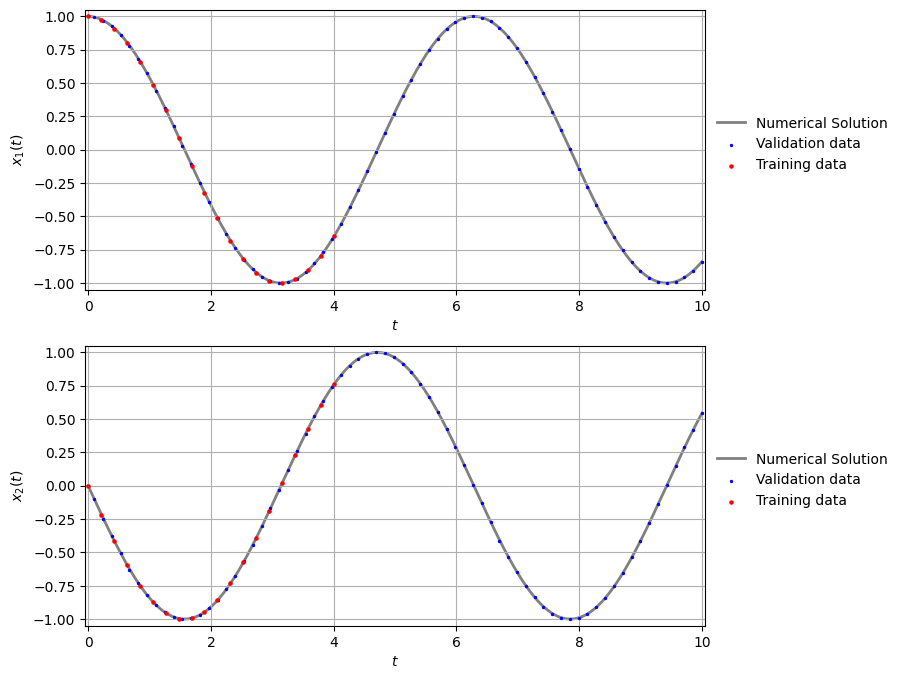

In [144]:
# Parameters and initial conditions
# w0^2 = g/L,

X0 = [1, 0]

# time domain
ti = 0
tf = 10
N  = 1000

t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution
def ODE(X, t):
    dXdt = [X[1], -X[0]]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 20
t_data  = torch.linspace(ti, tf*0.4, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data = training_data[:,0].view(-1,1)
x2_data = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 70
t_val  = torch.linspace(ti+0.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val = validation_data[:,0].view(-1,1)
x2_val = validation_data[:,1].view(-1,1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(t, x1, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[0].scatter(t_val, x1_val, color="blue", label="Validation data", s=2, zorder=2)
axes[0].scatter(t_data, x1_data, color="red", label="Training data", s=5, zorder=3)
axes[0].set_xlim(ti-.05, tf+0.05)
axes[0].set_ylim(-x1_max-.05, x1_max+0.05)
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$x_1(t)$')
axes[0].legend(frameon=False, loc=(1.01, 0.40))
axes[0].grid()

axes[1].plot(t, x2, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[1].scatter(t_val, x2_val, color="blue", label="Validation data", s=2, zorder=2)
axes[1].scatter(t_data, x2_data, color="red", label="Training data", s=5, zorder=3)
axes[1].set_xlim(ti-.05, tf+0.05)
axes[1].set_ylim(-x2_max-.05, x2_max+0.05)
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x_2(t)$')
axes[1].legend(frameon=False, loc=(1.01, 0.40))
axes[1].grid()

plt.show()

## PINN

In [145]:
# Define Neural Network Structure

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, ti, tf):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)
                        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.scale = lambda T : (T - ti)/(tf-ti)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [146]:
# Define the sample locations for physics loss
N_phys = 200
t_physics = torch.tensor(
    [0.5*(tf+ti) + 0.5*(tf-ti)*np.cos((i+0.5)/N_phys * np.pi) for i in range(N_phys)], dtype=torch.float32
    ).view(-1,1).requires_grad_(True)
# t_physics  = torch.linspace(ti + 0.1, tf, 200).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

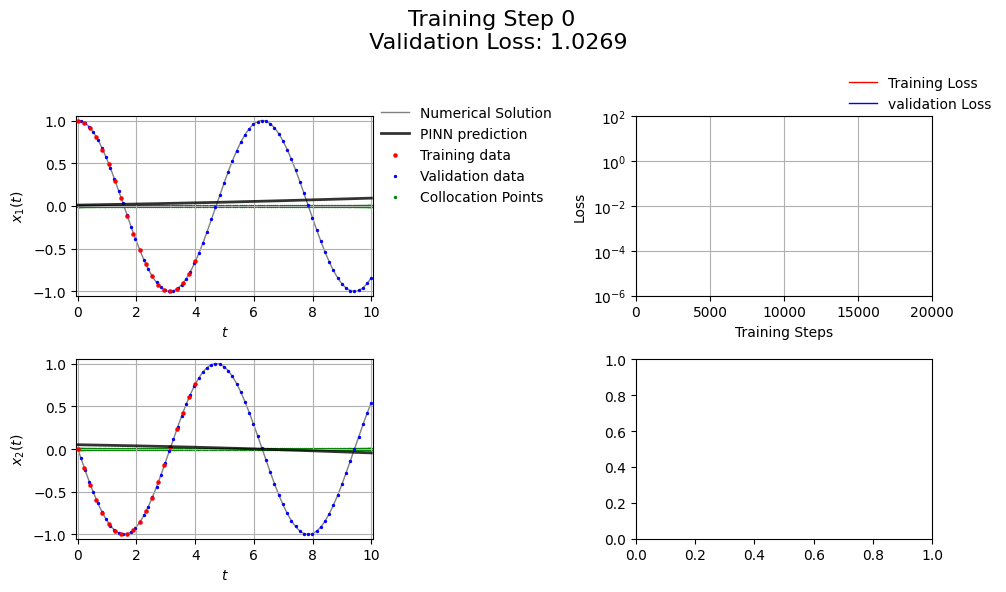

In [ ]:
# PINN

torch.manual_seed(123)

# Define PINN model. 1 input, 1 output, 3 hidden layers of 32 nodes.
PINN = FCN(1, 2, 16, 3, ti, tf)

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = 1e-4)

# Exponential scheduler, multiplies learning rate (lr) by gamma every 2000 epochs
# set gamma to 1 to basically disable
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

# Number of training steps
epochs = 20_000 + 1

# Weights for loss function
l1 = 1e0
l2 = 1e0

# used for making the gif
files = []

# stores loss values
training_loss   = []
validation_loss = []


for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss for position
    U = PINN(t_training)
    u1 = U[:,0].view(-1,1)
    u2 = U[:,1].view(-1,1)

    u1_loss = (u1 - x1_data)**2
    u2_loss = (u2 - x2_data)**2
    
    data_loss = torch.mean(u1_loss) + torch.mean(u2_loss)
    
    du1 = torch.autograd.grad(u1, t_training, torch.ones_like(u1), create_graph=True)[0]
    du2 = torch.autograd.grad(u2, t_training, torch.ones_like(u2), create_graph=True)[0]
    du1_loss = (du1 - (u2))**2
    du2_loss = (du2 - (-u1))**2
    
    
    derivative_loss = torch.mean(du1_loss) + torch.mean(du2_loss)
    
    # Compute the ODE loss
    V   = PINN(t_physics)
    v1  = V[:,0].view(-1,1)
    v2  = V[:,1].view(-1,1)
    
    dv1 = torch.autograd.grad(v1, t_physics, torch.ones_like(v1), create_graph=True)[0]
    dv2 = torch.autograd.grad(v2, t_physics, torch.ones_like(v2), create_graph=True)[0]
    
    ODE1_MSE = (dv1 - (v2))**2
    ODE2_MSE = (dv2 - (-v1))**2
    loss_ODE = torch.mean(ODE1_MSE) + torch.mean(ODE2_MSE)
    
    
    # Compute total loss
    loss = data_loss + l1*derivative_loss + l2*loss_ODE
    training_loss.append(loss.item())
    
    # Backpropagate the loss
    data_loss.backward()
    
    # Update the training weights
    optimizer.step()
    
    # every 1000 epochs, multiply learning rate by gamma
    if (i+1) % 1000 == 0: scheduler.step()
    
    
    # ===
    # Validation
    # ===

    PINN.eval()

    U_val = PINN(t_validation)
    u1_val = U_val[:,0].view(-1,1)
    u2_val = U_val[:,1].view(-1,1)
    
    MSE_1_val = (u1_val - x1_val)**2
    MSE_2_val = (u2_val - x2_val)**2
    loss_value_val = torch.mean(MSE_1_val + MSE_2_val)

    du1_val = torch.autograd.grad(u1_val, t_validation, torch.ones_like(u1_val), create_graph=True)[0]
    ODE1_val = (du1_val - (-u2_val))**2

    du2_val = torch.autograd.grad(u2_val,  t_validation, torch.ones_like(u2_val),  create_graph=True)[0]
    ODE2_val = (du2_val - (u1_val))**2
    
    loss_ODE_val = torch.mean(ODE1_val + ODE2_val)

    loss_val = loss_value_val + l1*loss_ODE_val
    validation_loss.append(loss_val.item())
    
    # ===
    # Plotting
    # ===
    
    if (i % 5_000) == 0: 
        P  = PINN(t).detach()
        p1 = P[:,0]
        p2 = P[:,1]
        tp = t_physics.detach()
        
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
        fig.suptitle(f"Training Step {i} \n Validation Loss: {loss_val.item():.4f}", fontsize=16)

        axes[0,0].plot(t, x1, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
        axes[0,0].plot(t, p1, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
        axes[0,0].scatter(t_data, x1_data, color="red", label="Training data", s=5, zorder=3)
        axes[0,0].scatter(t_val, x1_val, color="blue", label="Validation data", s=2, zorder=2)
        axes[0,0].scatter(tp, 0*torch.ones_like(tp), color="green", label="Collocation Points", s=2, zorder=1)
        axes[0,0].set_xlim(ti-.05, tf+0.05)
        axes[0,0].set_ylim(-x1_max-.05, x1_max+0.05)
        axes[0,0].set_xlabel('$t$')
        axes[0,0].set_ylabel('$x_1(t)$')
        axes[0,0].legend(frameon=False, loc=(1.01, 0.48))
        axes[0,0].grid()

        axes[1,0].plot(t, x2, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
        axes[1,0].scatter(t_val, x2_val, color="blue", label="Validation data", s=2, zorder=2)
        axes[1,0].scatter(t_data, x2_data, color="red", label="Training data", s=5, zorder=3)
        axes[1,0].scatter(tp, 0*torch.ones_like(tp), color="green", label="Collocation Points", s=2, zorder=1)
        axes[1,0].plot(t, p2, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
        axes[1,0].set_xlim(ti-.05, tf+0.05)
        axes[1,0].set_ylim(-x2_max-.05, x2_max+0.05)
        axes[1,0].set_xlabel('$t$')
        axes[1,0].set_ylabel('$x_2(t)$')
        axes[1,0].grid()
        
        axes[0,1].plot(np.arange(i+1), training_loss, label="Training Loss", color='red', lw=1)
        axes[0,1].plot(np.arange(i+1), validation_loss, label="validation Loss", color='blue', lw=1)
        axes[0,1].set_xlabel('Training Steps')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].set_xlim(0, epochs)
        axes[0,1].set_ylim(1e-6, 1e2)
        axes[0,1].set_yscale('log')
        axes[0,1].grid()
        axes[0,1].legend(frameon=False, loc=(0.7, 1))
 
        
        plt.tight_layout()
        if (i % 5_000) == 0: 
            plt.savefig("pinn_ode_solution.png", dpi=300, bbox_inches='tight')
            plt.show()
        else: 
            plt.close("all")